In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.92MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 23.5MB/s]


In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [6]:
len(dataloader)

3750

In [7]:
for image, cat in dataloader:
    break

In [8]:
image.size()

torch.Size([16, 1, 28, 28])

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)
        )
    def forward(self, x):
        return self.model(x)

In [10]:
critic = Critic()
generator = Generator()

In [11]:
optim_G = optim.RMSprop(generator.parameters(), lr=0.00005)
optim_C = optim.RMSprop(critic.parameters(), lr=0.00005)  # WGAN рекомендует RMSprop

# Убираем BCE loss
def clip_weights(model, clip_value=0.01):
    for p in model.parameters():
        p.data.clamp_(-clip_value, clip_value)

config.num_epochs = 20  # WGAN обучается дольше
config.critic_iters = 5  # Обычно критик обучают чаще генератора
config.clip_value = 0.01

In [15]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [17]:
ERRC_real = np.zeros(config.num_epochs)
ERRC_fake = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)

for epoch in range(config.num_epochs):
    for i, (images, _) in enumerate(dataloader):
        batch_size = images.size(0)
        images = images.view(batch_size, -1)

        # ---------- Обучение критика ----------
        for _ in range(config.critic_iters):
            critic.zero_grad()

            # Real
            real_score = critic(images).mean()

            # Fake
            noise = torch.randn(batch_size, config.noise_size)
            fake = generator(noise)
            fake_score = critic(fake.detach()).mean()

            # Critic loss: maximize D(real) - D(fake) → minimize D(fake) - D(real)
            loss_critic = fake_score - real_score
            loss_critic.backward()
            optim_C.step()

            # Weight clipping
            clip_weights(critic, config.clip_value)

            ERRC_real[epoch] += real_score.item()
            ERRC_fake[epoch] += fake_score.item()

        # ---------- Обучение генератора ----------
        generator.zero_grad()
        noise = torch.randn(batch_size, config.noise_size)
        fake = generator(noise)
        gen_score = critic(fake).mean()
        loss_gen = -gen_score  # maximize D(fake)
        loss_gen.backward()
        optim_G.step()

        ERRG[epoch] += gen_score.item()

        if (i + 1) % config.print_freq == 0:
            wasserstein_dist = real_score.item() - fake_score.item()
            print(f'Epoch {epoch+1}, Iter {i+1}: W ≈ {wasserstein_dist:.4f}')

Epoch 1, Iter 100: W ≈ 0.3989
Epoch 1, Iter 200: W ≈ 0.3027
Epoch 1, Iter 300: W ≈ 0.1990
Epoch 1, Iter 400: W ≈ 0.2129
Epoch 1, Iter 500: W ≈ 0.2269
Epoch 1, Iter 600: W ≈ 0.2443
Epoch 1, Iter 700: W ≈ 0.2432
Epoch 1, Iter 800: W ≈ 0.1827
Epoch 1, Iter 900: W ≈ 0.1841
Epoch 1, Iter 1000: W ≈ 0.1810
Epoch 1, Iter 1100: W ≈ 0.1356
Epoch 1, Iter 1200: W ≈ 0.1436
Epoch 1, Iter 1300: W ≈ 0.1372
Epoch 1, Iter 1400: W ≈ 0.0783
Epoch 1, Iter 1500: W ≈ 0.1280
Epoch 1, Iter 1600: W ≈ 0.1048
Epoch 1, Iter 1700: W ≈ 0.0324
Epoch 1, Iter 1800: W ≈ 0.0991
Epoch 1, Iter 1900: W ≈ 0.0614
Epoch 1, Iter 2000: W ≈ 0.0653
Epoch 1, Iter 2100: W ≈ 0.1081
Epoch 1, Iter 2200: W ≈ 0.0219
Epoch 1, Iter 2300: W ≈ 0.0375
Epoch 1, Iter 2400: W ≈ 0.0539
Epoch 1, Iter 2500: W ≈ 0.0452
Epoch 1, Iter 2600: W ≈ 0.0445
Epoch 1, Iter 2700: W ≈ 0.0796
Epoch 1, Iter 2800: W ≈ 0.0820
Epoch 1, Iter 2900: W ≈ 0.0827
Epoch 1, Iter 3000: W ≈ 0.0834
Epoch 1, Iter 3100: W ≈ 0.0530
Epoch 1, Iter 3200: W ≈ 0.0665
Epoch 1, Iter 330

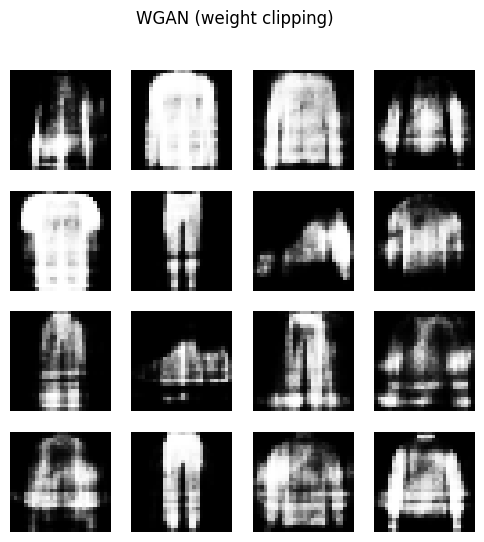

In [18]:
noise = torch.randn(16, config.noise_size)
fake = generator(noise)
plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('WGAN (weight clipping)')
plt.show()

In [20]:
optim_G = optim.Adam(generator.parameters(), lr=1e-4)
optim_C = optim.Adam(critic.parameters(), lr=1e-4)

config.lambda_gp = 10
config.critic_iters = 5
config.num_epochs = 20

In [21]:
def compute_gradient_penalty(critic, real_samples, fake_samples):
    batch_size = real_samples.size(0)
    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand_as(real_samples).to(real_samples.device)

    interpolates = alpha * real_samples + (1 - alpha) * fake_samples
    interpolates = interpolates.requires_grad_(True)

    d_interpolates = critic(interpolates)
    fake = torch.ones(d_interpolates.size(), requires_grad=False)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [22]:
ERRC_wass = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)

for epoch in range(config.num_epochs):
    for i, (images, _) in enumerate(dataloader):
        batch_size = images.size(0)
        real = images.view(batch_size, -1)

        # -------- Critic --------
        for _ in range(config.critic_iters):
            critic.zero_grad()
            noise = torch.randn(batch_size, config.noise_size)
            fake = generator(noise)

            real_score = critic(real).mean()
            fake_score = critic(fake.detach()).mean()

            gp = compute_gradient_penalty(critic, real, fake.detach())
            loss_critic = fake_score - real_score + config.lambda_gp * gp
            loss_critic.backward()
            optim_C.step()

            ERRC_wass[epoch] += (real_score - fake_score).item()

        # -------- Generator --------
        generator.zero_grad()
        noise = torch.randn(batch_size, config.noise_size)
        fake = generator(noise)
        gen_score = critic(fake).mean()
        loss_gen = -gen_score
        loss_gen.backward()
        optim_G.step()
        ERRG[epoch] += gen_score.item()

        if (i + 1) % config.print_freq == 0:
            print(f'Epoch {epoch+1}, Iter {i+1}: W ≈ {real_score.item() - fake_score.item():.4f}, GP: {gp.item():.2f}')

Epoch 1, Iter 100: W ≈ -1.3418, GP: 0.01
Epoch 1, Iter 200: W ≈ 2.1177, GP: 0.01
Epoch 1, Iter 300: W ≈ 1.0504, GP: 0.01
Epoch 1, Iter 400: W ≈ 0.2747, GP: 0.01
Epoch 1, Iter 500: W ≈ 2.1357, GP: 0.00
Epoch 1, Iter 600: W ≈ 0.8907, GP: 0.01
Epoch 1, Iter 700: W ≈ 0.3191, GP: 0.00
Epoch 1, Iter 800: W ≈ 0.8690, GP: 0.00
Epoch 1, Iter 900: W ≈ 1.1075, GP: 0.00
Epoch 1, Iter 1000: W ≈ 0.8893, GP: 0.01
Epoch 1, Iter 1100: W ≈ 0.3230, GP: 0.00
Epoch 1, Iter 1200: W ≈ 0.1879, GP: 0.00
Epoch 1, Iter 1300: W ≈ -0.3540, GP: 0.00
Epoch 1, Iter 1400: W ≈ 0.0642, GP: 0.00
Epoch 1, Iter 1500: W ≈ -0.1055, GP: 0.00
Epoch 1, Iter 1600: W ≈ 1.2001, GP: 0.01
Epoch 1, Iter 1700: W ≈ 0.5055, GP: 0.02
Epoch 1, Iter 1800: W ≈ 0.6196, GP: 0.01
Epoch 1, Iter 1900: W ≈ 1.0280, GP: 0.00
Epoch 1, Iter 2000: W ≈ 1.1876, GP: 0.01
Epoch 1, Iter 2100: W ≈ 0.7127, GP: 0.01
Epoch 1, Iter 2200: W ≈ 0.8112, GP: 0.01
Epoch 1, Iter 2300: W ≈ 1.0616, GP: 0.01
Epoch 1, Iter 2400: W ≈ 1.6243, GP: 0.02
Epoch 1, Iter 2500: W 

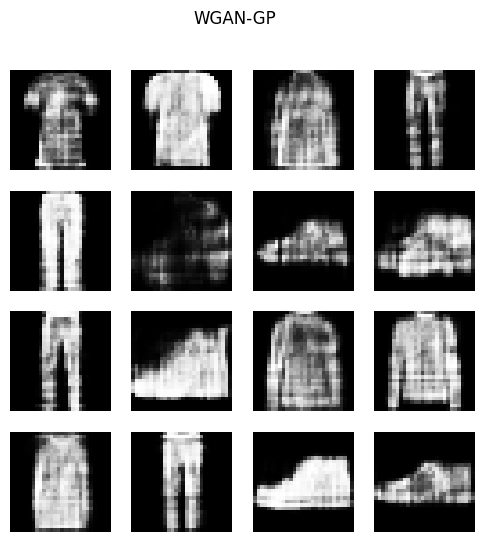

In [23]:
noise = torch.randn(16, config.noise_size)
fake = generator(noise)
plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('WGAN-GP')
plt.show()

In [24]:
class ConditionalGenerator(nn.Module):
    def __init__(self, n_classes=10, noise_dim=50, embed_dim=10):
        super().__init__()
        self.label_embedding = nn.Embedding(n_classes, embed_dim)
        self.model = nn.Sequential(
            nn.Linear(noise_dim + embed_dim, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid()
        )
    def forward(self, noise, labels):
        label_emb = self.label_embedding(labels)
        x = torch.cat([noise, label_emb], dim=1)
        return self.model(x)

class ConditionalCritic(nn.Module):
    def __init__(self, n_classes=10, embed_dim=10):
        super().__init__()
        self.label_embedding = nn.Embedding(n_classes, embed_dim)
        self.model = nn.Sequential(
            nn.Linear(28*28 + embed_dim, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)
        )
    def forward(self, x, labels):
        label_emb = self.label_embedding(labels)
        x = torch.cat([x, label_emb], dim=1)
        return self.model(x)

In [25]:
generator_cond = ConditionalGenerator()
critic_cond = ConditionalCritic()

In [26]:
optim_G = optim.Adam(generator_cond.parameters(), lr=1e-4)
optim_C = optim.Adam(critic_cond.parameters(), lr=1e-4)

In [27]:
def compute_gradient_penalty_cond(critic, real, fake, labels):
    batch_size = real.size(0)
    alpha = torch.rand(batch_size, 1).expand_as(real)
    interpolates = alpha * real + (1 - alpha) * fake
    interpolates = interpolates.requires_grad_(True)
    d_interpolates = critic(interpolates, labels)
    fake_grad = torch.ones(d_interpolates.size())
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake_grad,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(batch_size, -1)
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

In [28]:
config.num_epochs = 20

In [29]:
for epoch in range(config.num_epochs):
    for i, (images, labels) in enumerate(dataloader):
        batch_size = images.size(0)
        real = images.view(batch_size, -1)
        labels = labels  # shape: [batch]

        # Critic
        for _ in range(config.critic_iters):
            critic_cond.zero_grad()
            noise = torch.randn(batch_size, config.noise_size)
            fake = generator_cond(noise, labels)

            real_score = critic_cond(real, labels).mean()
            fake_score = critic_cond(fake.detach(), labels).mean()
            gp = compute_gradient_penalty_cond(critic_cond, real, fake.detach(), labels)
            loss_c = fake_score - real_score + config.lambda_gp * gp
            loss_c.backward()
            optim_C.step()

        # Generator
        generator_cond.zero_grad()
        noise = torch.randn(batch_size, config.noise_size)
        fake = generator_cond(noise, labels)
        gen_score = critic_cond(fake, labels).mean()
        loss_g = -gen_score
        loss_g.backward()
        optim_G.step()

        if (i + 1) % config.print_freq == 0:
            print(f'cWGAN-GP | Epoch {epoch+1}, Iter {i+1}: W ≈ {real_score.item() - fake_score.item():.4f}')

cWGAN-GP | Epoch 1, Iter 100: W ≈ 8.4856
cWGAN-GP | Epoch 1, Iter 200: W ≈ 6.0288
cWGAN-GP | Epoch 1, Iter 300: W ≈ 6.1654
cWGAN-GP | Epoch 1, Iter 400: W ≈ 5.8452
cWGAN-GP | Epoch 1, Iter 500: W ≈ 5.7309
cWGAN-GP | Epoch 1, Iter 600: W ≈ 4.8148
cWGAN-GP | Epoch 1, Iter 700: W ≈ 5.5308
cWGAN-GP | Epoch 1, Iter 800: W ≈ 6.0314
cWGAN-GP | Epoch 1, Iter 900: W ≈ 4.2330
cWGAN-GP | Epoch 1, Iter 1000: W ≈ 4.8543
cWGAN-GP | Epoch 1, Iter 1100: W ≈ 4.1379
cWGAN-GP | Epoch 1, Iter 1200: W ≈ 4.7558
cWGAN-GP | Epoch 1, Iter 1300: W ≈ 3.4582
cWGAN-GP | Epoch 1, Iter 1400: W ≈ 4.2662
cWGAN-GP | Epoch 1, Iter 1500: W ≈ 3.1916
cWGAN-GP | Epoch 1, Iter 1600: W ≈ 3.1703
cWGAN-GP | Epoch 1, Iter 1700: W ≈ 3.6344
cWGAN-GP | Epoch 1, Iter 1800: W ≈ 3.4208
cWGAN-GP | Epoch 1, Iter 1900: W ≈ 3.6165
cWGAN-GP | Epoch 1, Iter 2000: W ≈ 2.5347
cWGAN-GP | Epoch 1, Iter 2100: W ≈ 2.9055
cWGAN-GP | Epoch 1, Iter 2200: W ≈ 3.2905
cWGAN-GP | Epoch 1, Iter 2300: W ≈ 3.4125
cWGAN-GP | Epoch 1, Iter 2400: W ≈ 3.2292
c

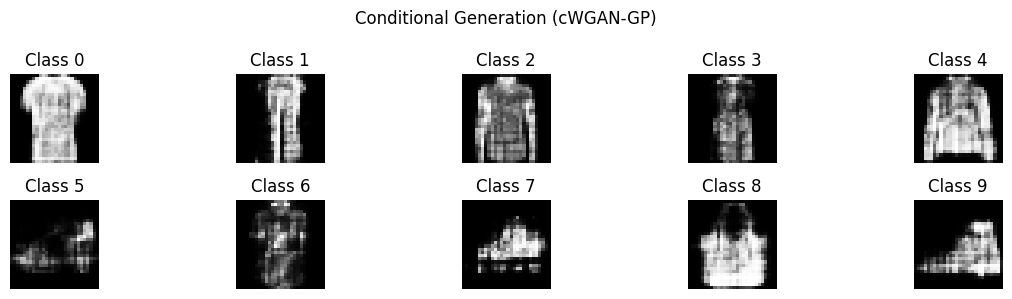

In [30]:
# Генерируем по одному изображению на каждый класс
n_classes = 10
noise = torch.randn(n_classes, config.noise_size)
labels = torch.arange(n_classes)  # [0,1,2,...,9]

fake_cond = generator_cond(noise, labels)

plt.figure(figsize=(12, 3))
for i in range(n_classes):
    plt.subplot(2, 5, i+1)
    plt.imshow(fake_cond[i].detach().numpy().reshape(28, 28), cmap='gray')
    plt.title(f'Class {i}')
    plt.axis('off')
plt.suptitle('Conditional Generation (cWGAN-GP)')
plt.tight_layout()
plt.show()